In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# fractal

> Fill in a module description here

In [ ]:
#| default_exp fractal

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from abc import abstractmethod
import numpy as np
from fractalart.core import Image
from numba import njit, prange
import math
import matplotlib.pyplot as plt

In [ ]:
#| export
class Fractal(Image):
    """Abstract base class for generating fractal images."""

    @abstractmethod
    def compute(self) -> np.ndarray:
        """Abstract method to compute the fractal array. Must be implemented by subclasses."""
        pass

    @property
    def max_iter(self) -> int:
        """Maximum number of iterations used in fractal computation."""
        return self._max_iter

    @max_iter.setter
    def max_iter(self, value: int):
        if value <= 0:
            raise ValueError("max_iter must be a positive integer.")
        self._max_iter = value

    def plot(self, cmap: str = "turbo"):
        """Display the rendered fractal image using matplotlib."""
        # TODO : Us lighter image plotting, e. g. using PIL.Image or cv2
        plt.figure(figsize=(8, 8))
        plt.imshow(
            self._image,
            cmap=cmap,
            extent=[self._x_min, self._x_max, self._y_min, self._y_max],
            origin='lower'
        )
        plt.axis('off')
        plt.show()
    
    def set_zoom(self, zoom: float, center: tuple[float, float]):
        """
        Zoom into the fractal at a specific center.

        Args:
            zoom: Zoom factor (higher is closer).
            center: (x, y) center coordinates in the complex plane.
        """
        if zoom <= 0:
            raise ValueError("zoom must be a positive number.")
        cx, cy = center
        delta = (self._x_max - self._x_min) / (2 * zoom)
        self._x_min, self._x_max = cx - delta, cx + delta
        self._y_min, self._y_max = cy - delta, cy + delta

    def _render(self):
        """Generate and store the fractal image using the subclass-defined `compute` method."""
        self._image = self.compute()

In [ ]:
#| export
@njit(parallel=True, fastmath=True)
def _compute_fractal(x_min: float, x_max: float, y_min: float, y_max: float, resolution: tuple[int, int],
                     max_iter: int, fractal_fn, smooth: bool = True) -> np.ndarray:
    
    width, height = resolution
    result = np.zeros((height, width), dtype=np.float32)
    r2_cut = max(abs(x_max), abs(x_min)) * max(abs(x_max), abs(x_min)) + max(abs(y_max), abs(y_min)) * max(abs(y_max), abs(y_min))

    dx = (x_max - x_min) / (width - 1)
    dy = (y_max - y_min) / (height - 1)
    inv_log2 = 1.0 / math.log(2.0)

    for j in prange(height):
        zy = y_min + j * dy
        for i in range(width):
            zx = x_min + i * dx
            zr = 0.0
            zi = 0.0
            cr = zx
            ci = zy
            iteration = 0

            while zr * zr + zi * zi <= r2_cut and iteration < max_iter:
                zr, zi = fractal_fn(zr, zi, cr, ci)
                iteration += 1

            if smooth and iteration < max_iter:
                result[j, i] = sooth_colorig(zr, zi, iteration)
            else:
                result[j, i] = iteration

    return result

In [ ]:
#| export

_inv_log2 = 1.0 / math.log(2.0)

@njit
def sooth_colorig(zr, zi, iteration):
    mag_sq = zr * zr + zi * zi
    if mag_sq > 0.0:
        log_zn = 0.5 * math.log(mag_sq)
        if log_zn > 0.0:
            nu = math.log(log_zn * _inv_log2) * _inv_log2
            return iteration + 1 - nu
        else:
            return iteration
    else:
        return iteration

@njit
def mandelbrot_step_1(zr, zi, cr, ci):
    zr2 = zr * zr
    zi2 = zi * zi
    zr_new = zr2 - zi2 + cr
    zi_new = 2.0 * zr * zi + ci
    return zr_new, zi_new

@njit
def mandelbrot_step_3(zr, zi, cr, ci):
    zr2 = zr * zr
    zi2 = zi * zi
    zr3 = zr2 * zr
    zi3 = zi2 * zi
    zr_new = zr3 - 3.0 * zr * zi2 + cr
    zi_new = 3.0 * zr2 * zi - zi3 + ci
    return zr_new, zi_new

@njit
def mandelbrot_step_4(zr, zi, cr, ci):
    zr2 = zr * zr
    zi2 = zi * zi
    zr4 = zr2 * zr2
    zi4 = zi2 * zi2
    zr2zi2 = zr2 * zi2
    zr_new = zr4 - 6.0 * zr2zi2 + zi4 + cr
    zi_new = 4.0 * zr * zi * (zr2 - zi2) + ci
    return zr_new, zi_new

@njit
def mandelbrot_step_5(zr, zi, cr, ci):
    zr2 = zr * zr
    zi2 = zi * zi
    zr3 = zr2 * zr
    zi3 = zi2 * zi
    zr4 = zr3 * zr
    zi4 = zi3 * zi
    zr5 = zr4 * zr
    zi5 = zi4 * zi
    zrzi = zr * zi
    zrzi3 = zrzi * zi2  # zr * zi^3
    zr3zi = zr3 * zi    # zr^3 * zi
    zrzi3 = zr * zi3    # zr * zi^3
    zr_new = zr5 - 10.0 * zr3 * zi2 + 5.0 * zr * zi4 + cr
    zi_new = 5.0 * zr4 * zi - 10.0 * zr2 * zi3 + zi5 + ci
    return zr_new, zi_new

@njit
def julia_step(zr, zi, cr, ci):
    return mandelbrot_step(zr, zi, cr, ci)

@njit
def cross_dist(zr, zi):
    return min(abs(zr), abs(zi))

In [ ]:
#| export
class Mandelbrot(Fractal):
    def __init__(
        self,
        x_min: float = -2.0,
        x_max: float = 1.0,
        y_min: float = -1.5,
        y_max: float = 1.5,
        width: int = 600,
        height: int = 600,
        max_iter: int = 200,
    ):
        """Initialize the fractal with image resolution and complex plane bounds."""
        self._x_min, self._x_max = x_min, x_max
        self._y_min, self._y_max = y_min, y_max
        self.resolution = width, height
        self.max_iter = max_iter
        
    def compute(self) -> np.ndarray:
        w, h = self.resolution
        return _compute_fractal(self._x_min, self._x_max, self._y_min, self._y_max, self.resolution, self._max_iter, mandelbrot_step_1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


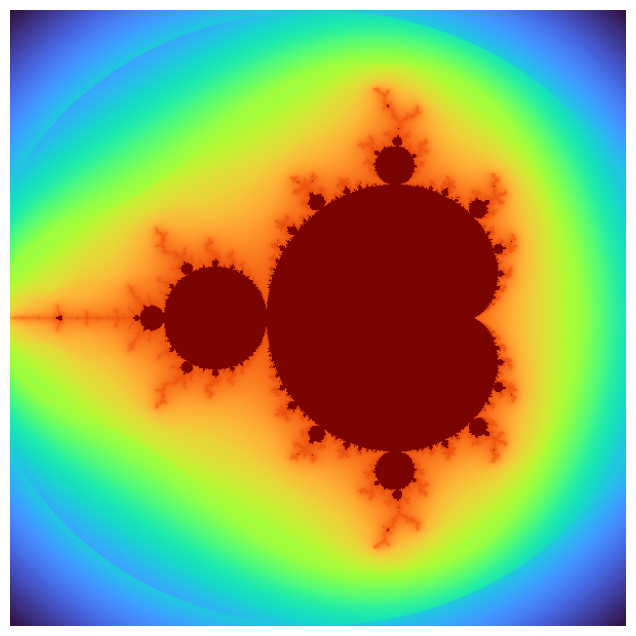

In [ ]:
m = Mandelbrot()
m.resolution = 600, 600
m.max_iter = 200
a = m.render()
m.equalize_histogram()
m.plot()

In [ ]:
#| export
@njit(parallel=True, fastmath=True)
def _compute_orbit_trap(x_min: float, x_max: float, y_min: float, y_max: float, resolution: tuple[int, int],
                     max_iter: int, fractal_fn, orbit_trap_fn) -> np.ndarray:
    
    width, height = resolution
    result = np.zeros((height, width), dtype=np.float32)
    r2_cut = max(abs(x_max), abs(x_min)) * max(abs(x_max), abs(x_min)) + max(abs(y_max), abs(y_min)) * max(abs(y_max), abs(y_min))

    dx = (x_max - x_min) / (width - 1)
    dy = (y_max - y_min) / (height - 1)
    inv_log2 = 1.0 / math.log(2.0)

    for j in prange(height):
        zy = y_min + j * dy
        for i in range(width):
            zx = x_min + i * dx
            zr = 0.0
            zi = 0.0
            cr = zx
            ci = zy
            iteration = 0
            min_cross = 1e10

            while iteration < max_iter:
                zr, zi = fractal_fn(zr, zi, cr, ci)
                iteration += 1
                if iteration > 2:
                    cross_dist = orbit_trap_fn(zr, zi)
                    if (cross_dist < min_cross):
                        min_cross = cross_dist

            result[j, i] = min_cross

    return result

In [ ]:
#| export
class MandelbrotCrossTrap(Fractal):
    def __init__(
        self,
        x_min: float = -2.0,
        x_max: float = 1.0,
        y_min: float = -1.5,
        y_max: float = 1.5,
        width: int = 600,
        height: int = 600,
        max_iter: int = 200,
    ):
        """Initialize the fractal with image resolution and complex plane bounds."""
        self._x_min, self._x_max = x_min, x_max
        self._y_min, self._y_max = y_min, y_max
        self.resolution = width, height
        self.max_iter = max_iter
        
    def compute(self) -> np.ndarray:
        w, h = self.resolution
        return _compute_orbit_trap(self._x_min, self._x_max, self._y_min, self._y_max,
                                self.resolution, self._max_iter, mandelbrot_step_1, cross_dist)

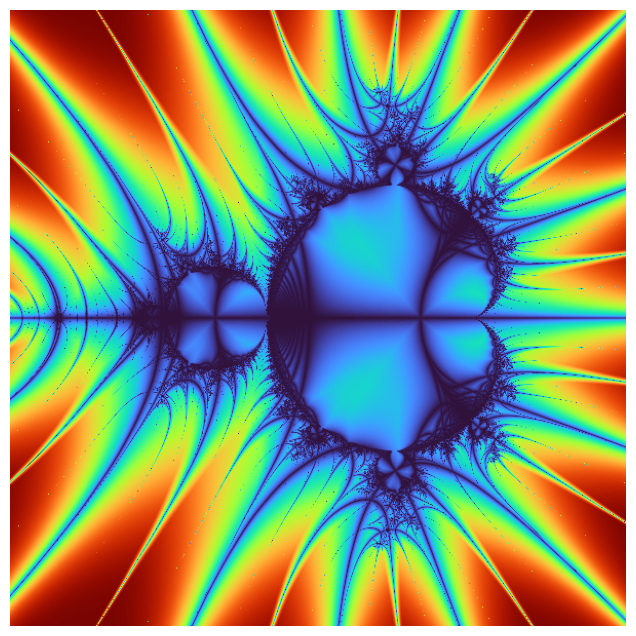

In [ ]:
m = MandelbrotCrossTrap()
m.resolution = 600, 600
m.max_iter = 200
a = m.render()
m.equalize_histogram()
m.plot()

In [ ]:
##| export
#@njit(parallel=True, fastmath=True)
#def _compute_mandelbrot(x_min: float, x_max: float, y_min: float, y_max: float, width: int, height: int, max_iter: int) -> np.ndarray:
#    # Allocate with float32 to halve memory bandwidth (optional)
#    result = np.zeros((height, width), dtype=np.float32)
#
#    dx = (x_max - x_min) / (width - 1)
#    dy = (y_max - y_min) / (height - 1)
#
#    inv_log2 = 1.0 / math.log(2.0)   # for nu calculation
#    r2_cut = max(abs(x_max), abs(x_min)) * max(abs(x_max), abs(x_min)) + max(abs(y_max), abs(y_min)) * max(abs(y_max), abs(y_min))
#
#    for j in prange(height):
#        zy = y_min + j * dy
#        for i in range(width):
#            zx = x_min + i * dx
#            zr = 0.0
#            zi = 0.0
#            cr = zx
#            ci = zy
#            iteration = 0
#
#            # Mandelbrot iteration
#            while zr * zr + zi * zi <= r2_cut and iteration < max_iter:
#                # TODO : use zr * zr + zi * zi <= 4 and iteration < max_iter for classical fractal calculation without orbit traps
#                # (zr + i zi)^2 + c
#                zr2 = zr * zr - zi * zi + cr
#                zi = 2.0 * zr * zi + ci
#                zr = zr2
#                iteration += 1
#
#            if iteration < max_iter:
#                mag_sq = zr * zr + zi * zi
#                if mag_sq > 0.0:
#                    log_zn = 0.5 * math.log(mag_sq)
#                    if log_zn > 0.0:
#                        nu = math.log(log_zn * inv_log2) * inv_log2
#                        result[j, i] = iteration + 1 - nu
#                    else:
#                        result[j, i] = iteration
#                else:
#                    result[j, i] = iteration
#            else:
#                result[j, i] = iteration
#
#    return result
#
#class Mandelbrot(Fractal):
#    def compute(self) -> np.ndarray:
#        w, h = self.resolution
#        # pass resolution-consistent dims
#        return _compute_mandelbrot(self._x_min, self._x_max, self._y_min, self._y_max, w, h, self._max_iter)

In [ ]:
##| export
#@njit(parallel=True, fastmath=True)
#def _compute_mandelbrot_cross_trap(x_min: float, x_max: float, y_min: float, y_max: float, width: int, height: int, max_iter: int) -> np.ndarray:
#    # Allocate with float32 to halve memory bandwidth (optional)
#    cross_trap = np.zeros((height, width), dtype=np.float32)
#
#    dx = (x_max - x_min) / (width - 1)
#    dy = (y_max - y_min) / (height - 1)
#
#    inv_log2 = 1.0 / math.log(2.0)   # for nu calculation
#
#    for j in prange(height):
#        zy = y_min + j * dy
#        for i in range(width):
#            zx = x_min + i * dx
#            zr = 0.0
#            zi = 0.0
#            cr = zx
#            ci = zy
#            iteration = 0
#            min_cross = 1e10
#
#            # Mandelbrot iteration
#            while iteration < max_iter:
#                # TODO : use zr * zr + zi * zi <= 4 and iteration < max_iter for classical fractal calculation without orbit traps
#                # (zr + i zi)^2 + c
#                zr2 = zr * zr - zi * zi + cr
#                zi = 2.0 * zr * zi + ci
#                zr = zr2
#                iteration += 1
#
#                # Cross trap: distance to real or imaginary axis
#                # TOTO : only take the min after a specific number of iterations , e. g. iteration > 3:
#                if iteration > 2:
#                    cross_dist = min(abs(zr), abs(zi))
#                    if (cross_dist < min_cross):
#                        min_cross = cross_dist
#
#            cross_trap[j, i] = min_cross
#
#    return cross_trap
#
#class MandelbrotCrossTrap(Fractal):
#    def compute(self) -> np.ndarray:
#        w, h = self.resolution
#        # pass resolution-consistent dims
#        return _compute_mandelbrot_cross_trap(self._x_min, self._x_max, self._y_min, self._y_max, w, h, self._max_iter)

In [ ]:
##| export
#@njit(parallel=True, fastmath=True)
#def _compute_julia_set(xmin, xmax, ymin, ymax, width, height, cr, ci, max_iter):
#    dx = (xmax - xmin) / (width - 1)
#    dy = (ymax - ymin) / (height - 1)
#    result = np.zeros((height, width), dtype=np.float32)
#
#    for j in prange(height):
#        y0 = ymin + j * dy
#        for i in range(width):
#            x0 = xmin + i * dx
#            x = x0
#            y = y0
#            iteration = 0
#            while x*x + y*y <= 6.25 and iteration < max_iter:
#                x_temp = x*x - y*y + cr
#                y = 2.0 * x * y + ci
#                x = x_temp
#                iteration += 1
#
#            if iteration < max_iter:
#                # Smooth coloring
#                modulus_sq = x*x + y*y
#                log_zn = np.log(modulus_sq) / 2
#                nu = np.log(log_zn / np.log(2)) / np.log(2)
#                result[j, i] = iteration + 1 - nu
#            else:
#                result[j, i] = max_iter
#
#    return result
#
#class Julia(Fractal):
#    def __init__(
#        self,
#        cr: float = -0.7,
#        ci: float = 0.27015,
#        width: int = 800,
#        height: int = 800,
#        x_min: float = -1.5,   # override Fractal default
#        x_max: float =  1.5,   # override Fractal default
#        y_min: float = -1.5,   # keep same (or change)
#        y_max: float =  1.5,   # keep same (or change)
#        max_iter: int = 1000,  # keep same (or change)
#    ):
#        # 1) initialize the Fractal portion:
#        super().__init__(width, height, x_min, x_max, y_min, y_max, max_iter)
#
#        # 2) store Julia‐specific constants
#        self._cr = cr
#        self._ci = ci
#        
#    def compute(self) -> np.ndarray:
#        w, h = self.resolution
#        # pass resolution-consistent dims
#        return _compute_julia_set(self._x_min, self._x_max, self._y_min, self._y_max, w, h, self._cr, self._ci, self._max_iter)

In [ ]:
#j = Julia(cr = -0.7, ci = 0.27015)
#j.resolution = 1200, 1200
#j.max_iter = 3000
#j.render()
#j.equalize_histogram()
#j.plot()

In [ ]:
##| export
#@njit(parallel=True, fastmath=True)
#def _compute_julia_cross_trap(xmin, xmax, ymin, ymax, width, height, cr, ci, max_iter):
#    dx = (xmax - xmin) / (width - 1)
#    dy = (ymax - ymin) / (height - 1)
#    cross_trap = np.zeros((height, width), dtype=np.float32)
#
#    for j in prange(height):
#        y0 = ymin + j * dy
#        for i in range(width):
#            x0 = xmin + i * dx
#            x = x0
#            y = y0
#            iteration = 0
#            min_cross = 1e10
#            
#            while iteration < max_iter:
#                x_temp = x*x - y*y + cr
#                y = 2.0 * x * y + ci
#                x = x_temp
#                iteration += 1
#
#                # Cross trap: distance to real or imaginary axis
#                # TOTO : only take the min after a specific number of iterations , e. g. iteration > 3:
#                if iteration > -1:
#                    cross_dist = min(abs(x), abs(y))
#                    if (cross_dist < min_cross):
#                        min_cross = cross_dist
#
#            cross_trap[j, i] = min_cross
#
#    return cross_trap
#
#class JuliaCrossTrap(Fractal):
#    def __init__(
#        self,
#        cr: float = -0.7,
#        ci: float = 0.27015,
#        width: int = 800,
#        height: int = 800,
#        x_min: float = -1.5,   # override Fractal default
#        x_max: float =  1.5,   # override Fractal default
#        y_min: float = -1.5,   # keep same (or change)
#        y_max: float =  1.5,   # keep same (or change)
#        max_iter: int = 1000,  # keep same (or change)
#    ):
#        # 1) initialize the Fractal portion:
#        super().__init__(width, height, x_min, x_max, y_min, y_max, max_iter)
#
#        # 2) store Julia‐specific constants
#        self._cr = cr
#        self._ci = ci
#        
#    def compute(self) -> np.ndarray:
#        w, h = self.resolution
#        # pass resolution-consistent dims
#        return _compute_julia_cross_trap(self._x_min, self._x_max, self._y_min, self._y_max, w, h, self._cr, self._ci, self._max_iter)

In [ ]:
#j = JuliaCrossTrap(cr = 0.355, ci = 0.355)
#j.resolution = 1200, 1200
#j.max_iter = 3000
#j.render()
#j.equalize_histogram()
#j.plot()

In [ ]:
#j = Julia(cr = -0.4, ci = 0.6)
#j.resolution = 1200, 1200
#j.max_iter = 3000
#j.render()
#j.equalize_histogram()
#j.plot()

In [ ]:
#j = Julia(cr = -0.8, ci = 0.156)
#j.resolution = 1200, 1200
#j.max_iter = 3000
#j.render()
#j.equalize_histogram()
#j.plot()

In [ ]:
#m = Mandelbrot()
#m.resolution = 1200, 1200
#m.max_iter = 3000
#m.set_zoom(1, (0.0, 0.0))
#m.render()
#m.equalize_histogram()
#m.plot()

In [ ]:
#m = MandelbrotCrossTrap()
#m.resolution = 1200, 1200
#m.max_iter = 3000
#m.set_zoom(2, (0.0, 0.0))
#m.render()
#m.equalize_histogram()
#m.plot()

In [ ]:
#m = MandelbrotCrossTrap()
#m.resolution = 1200, 1200
#m.max_iter = 3000
#
##m.set_zoom(5, (-0.170337,-1.06506))
##m.set_zoom(25, (-0.170337,-1.06506))
##m.set_zoom(125, (-0.170337,-1.06506))
##m.set_zoom(625, (-0.170337,-1.06506))
##m.set_zoom(3125, (-0.170337,-1.06506))
##m.set_zoom(15625, (-0.170337,-1.06506))
##m.set_zoom(78125, (-0.170337,-1.06506))
#
##m.set_zoom(5, (0.42884,-0.231345))
##m.set_zoom(25, (0.42884,-0.231345))
#m.set_zoom(125, (0.42884,-0.231345))
##m.set_zoom(625, (0.42884,-0.231345))
##m.set_zoom(3125, (0.42884,-0.231345))
##m.set_zoom(15625, (0.42884,-0.231345))
##m.set_zoom(78125, (0.42884,-0.231345))
#
##m.set_zoom(5, (-1.62917,-0.0203968))
##m.set_zoom(25, (-1.62917,-0.0203968))
##m.set_zoom(125, (-1.62917,-0.0203968))
##m.set_zoom(625, (-1.62917,-0.0203968))
##m.set_zoom(3125, (-1.62917,-0.0203968))
##m.set_zoom(15625, (-1.62917,-0.0203968))
##m.set_zoom(78125, (-1.62917,-0.0203968))
#
##m.set_zoom(5, (-0.761574,-0.0847596))
##m.set_zoom(25, (-0.761574,-0.0847596))
##m.set_zoom(125, (-0.761574,-0.0847596))
##m.set_zoom(625, (-0.761574,-0.0847596))
##m.set_zoom(3125, (-0.761574,-0.0847596))
##m.set_zoom(15625, (-0.761574,-0.0847596))
##m.set_zoom(78125, (-0.761574,-0.0847596))
#
#m.render()
#m.equalize_histogram()
#m.plot()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()